# KANN: Koopman Analysis of Neural Networks

This code shows highlighting of positive and negative words (unigrams) using the dominant eigenvectors of the Koopman operator over trained GRU on sentiment classification using the IMDB reviews dataset.

### Imports

In [1]:
!pip install kann

Defaulting to user installation because normal site-packages is not writeable
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
import torch
import numpy as np
import argparse
from tqdm import tqdm

import kann

### Hyperparameters

define hyperparamas and load data (IMDB reviews dataset)

In [3]:
# hyperparameters
parser = argparse.ArgumentParser(description="Sentiment Analysis Task")
parser.add_argument("-f")
parser.add_argument("--epochs", type=int, default=4)
parser.add_argument("--batch_size", type=int, default=64)
parser.add_argument("--hidden_size", type=int, default=256)
parser.add_argument("--embed_dim", type=int, default=128)
parser.add_argument("--output_dim", type=int, default=1)
parser.add_argument("--num_layers", type=int, default=1)
parser.add_argument("--clip", type=int, default=15)
parser.add_argument("--lr", type=float, default=5e-3)
parser.add_argument("--decay_rate", type=float, default=0.5)
parser.add_argument("--weight_decay", type=float, default=1e-3)


args = parser.parse_args()

seed = 1234
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
np.random.seed(seed)

suff = 'lr={:.5f}_dr={:.5f}_wd={:.5f}'.format(args.lr, args.decay_rate, args.weight_decay)

# Use cuda if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
args.device = device


# various task parameters
vocab_file = 'imdb.vocab'
train_data = kann.imdb('train', vocab_file)
test_data = kann.imdb('test', vocab_file)
test_dset = kann.get_as_list(test_data)

with open(vocab_file, 'r') as f:
    vocab = f.readlines()
vocab_size = len(vocab)
args.vocab_size = vocab_size

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


### Create model (GRU), build train and eval step function

In [4]:
# create model and optimizer
model = kann.Model(args.embed_dim, args.hidden_size, args.output_dim, args).to(device)
opt, lr_sched = kann.create_opt(model, args)


def train():

    epoch_tr_loss, epoch_te_loss = [], []
    epoch_tr_acc, epoch_te_acc = [], []
    best_test_acc = 0

    for epoch in range(args.epochs):
        # train for an epoch
        train_losses, train_acc = train_epoch()

        # eval on the test set
        test_losses, test_acc = eval_epoch()

        epoch_tr_loss.append(np.mean(train_losses))
        epoch_te_loss.append(np.mean(test_losses))
        epoch_tr_acc.append(np.mean(train_acc))
        epoch_te_acc.append(np.mean(test_acc))
        best_test_acc = max(best_test_acc, epoch_te_acc[-1])

        print('Epoch {}'.format(epoch + 1))
        print('train_loss: {:.4f} test_loss: {:.4f}'.format(epoch_tr_loss[-1], epoch_te_loss[-1]))
        print('train_accuracy: {:.4f} test_accuracy: {:.4f}'.format(epoch_tr_acc[-1] * 100, epoch_te_acc[-1] * 100))
        print(3 * '==')
    torch.save(model.state_dict(), 'gru_model_weights_{}.pt'.format(suff))


def train_epoch():
    model.train()
    h = model.init_hidden(args.batch_size)
    train_losses, train_acc = [], []

    for batch in tqdm(train_data.as_numpy_iterator()):
        inputs = torch.from_numpy(batch['inputs']).to(device)
        labels = torch.from_numpy(batch['labels']).to(device)

        model.zero_grad()
        logits, h = model(inputs, h, batch['index'])
        loss = model.loss(logits.squeeze(), labels.float())

        torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
        loss.backward()
        opt.step()

        # stats
        train_losses.append(loss.item())
        train_acc.append(model.accuracy(logits, labels))

        h = h.detach()

    lr_sched.step()

    return train_losses, train_acc


def eval_epoch():
    model.eval()
    test_h = model.init_hidden(args.batch_size)
    test_losses, test_acc = [], []
    with torch.no_grad():
        for batch in tqdm(test_data.as_numpy_iterator()):
            inputs = torch.from_numpy(batch['inputs']).to(device)
            labels = torch.from_numpy(batch['labels']).to(device)

            logits, test_h = model(inputs, test_h, batch['index'])
            test_loss = model.loss(logits.squeeze(), labels.float())

            test_losses.append(test_loss.item())
            test_acc.append(model.accuracy(logits, labels))

        return test_losses, test_acc



### Run training loop or immediately load GRU model weights

In [5]:
# train()

with open('gru_weights_{}.pt'.format(suff), 'rb') as f:
    model.load_state_dict(torch.load(f, map_location=torch.device(device)))

###  Highlighting of positive and negative words (unigrams) using the dominant eigenvectors of the Koopman operator

['watched', 'this', 'on', 'k', '##q', '##ed,', 'with', 'frank', 'baxter', 'commenting', '##,', 'as', 'i', 'recall', '##.', 'have', 'never', 'seen', 'it', 'since,', 'but', 'would', 'like', 'to', 'find', 'out', 'where', 'it', 'is', 'available.', '##<br', '/><br', '/>it', 'is', 'amazing', 'how', 'good', 'something', 'can', 'be,', 'but', 'be', 'in', 'black', 'and', 'white,', 'and', 'have', 'zero', 'special', 'effects.', 'in', 'fact,', 'amazing', 'how', 'much', 'better', 'something', 'like', 'that', 'is!']
['what', 'a', 'mess', 'of', 'a', 'movie!', 'if', 'it', 'wasnt', 'for', 'eric', 'roberts', 'and', 'susan', 'sarandon', "##'s", 'performances', ',', '##this', 'movie', 'would', 'be', 'a', 'total', 'waste', '##!', 'a', 'very', 'muddled', 'plot', 'and', 'phony', 'dialogue.', '##eric', 'roberts', 'debut.', '##...', '##where', 'did', 'his', 'career', 'go', 'from', 'this', 'movie', 'on?', '##now', '##here', 'but', 'down!']


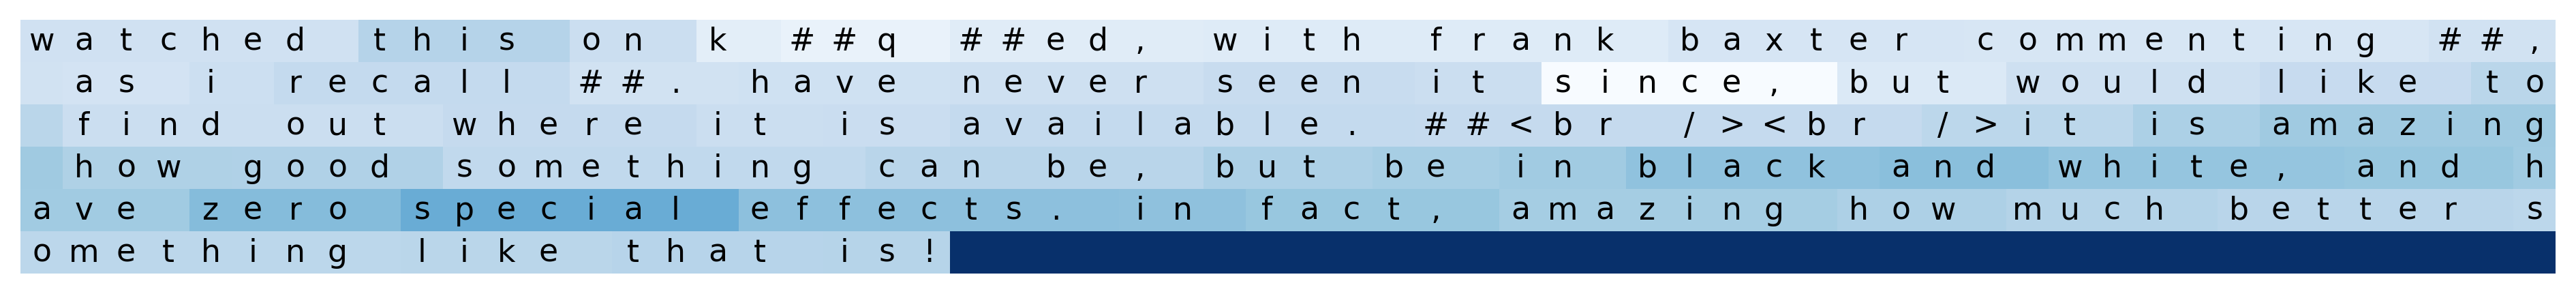

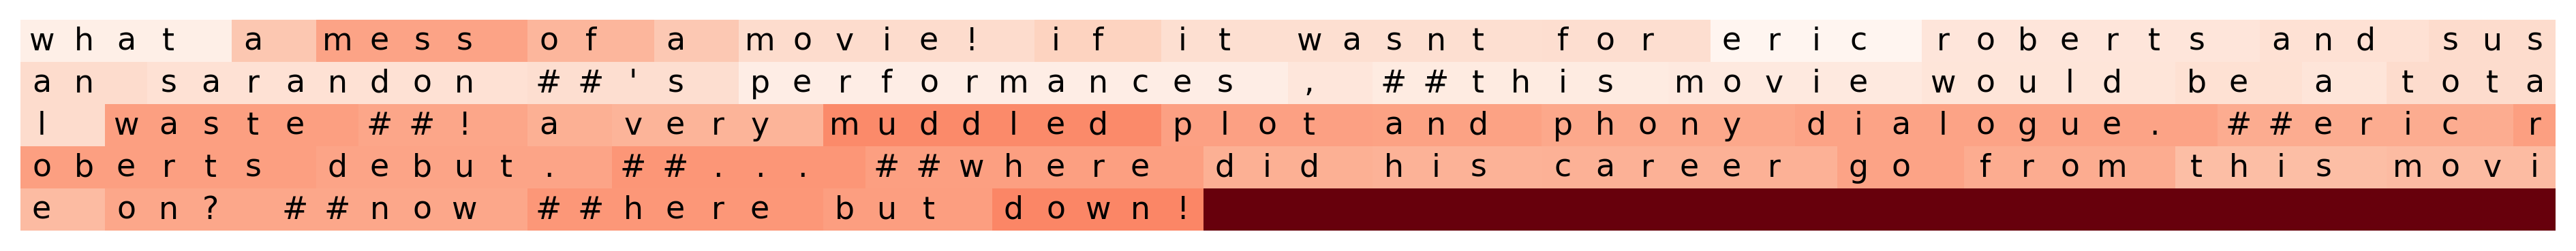

In [6]:

batch1 = test_dset[347]
test_x1, test_z1 = batch1['inputs'], batch1['index']
Zpvn1, eig_idx1 = kann.compute_projection_magnitude(model, batch1, device)

# plot positive & negative shaded reviews
idx = 17        # positive
rev_text1 = " ".join(kann.print_review(vocab, test_x1[idx], test_z1[idx]))
kann.plot_shaded_review('sa_pos_rev', rev_text1, Zpvn1[idx, :test_z1[idx], eig_idx1[2]], 'Blues')


batch2 = test_dset[199]
test_x2, test_z2 = batch2['inputs'], batch2['index']
Zpvn2, eig_idx2 = kann.compute_projection_magnitude(model, batch2, device)

idx = 34        # negative\
rev_text2 = " ".join(kann.print_review(vocab, test_x2[idx], test_z2[idx]))
kann.plot_shaded_review('sa_neg_rev', rev_text2, Zpvn2[idx, :, eig_idx2[1]], 'Reds')
